# LSH算法

## 1.LSH 算法原理分步详解

**🧩 LSH 算法原理分步详解（Locality-Sensitive Hashing）**

---

### 一、核心思想

> **目的**：在高维空间中快速找到“相似”的数据点。  
> **关键思想**：让相似的样本在哈希后 **落入同一个桶（bucket）** 的概率高，不相似的样本落入同桶的概率低。

相比暴力搜索（O(N)），LSH 通过 **多组随机哈希函数** 将搜索复杂度降低到 **亚线性（sublinear）**。

---

### 二、适用场景

| 相似度度量 | 常用 LSH 变体 | 哈希思想 |
|-------------|----------------|-----------|
| 余弦相似度（cosine similarity） | Random Projection LSH | 用随机超平面划分空间 |
| 欧式距离（L2 distance） | p-stable LSH | 用随机投影 + 模运算近似欧氏距离 |
| Jaccard 相似度（集合相似度） | MinHash LSH | 利用最小哈希值近似集合交并比 |

---

### 三、算法原理分步讲解（以余弦相似度为例）

#### 第 1 步：构建随机超平面（Random Hyperplanes）

- 在 d 维空间随机生成 k 个向量
  $$
  ( r_1, r_2, \ldots, r_k )
  $$
  每个向量的分量服从标准正态分布
  $$
   N(0,1) 
  $$
  
- 每个超平面代表一个随机方向。

---

#### 第 2 步：计算哈希签名（Hash Signature）

对于一个向量 \( x \)，通过计算：

$$
h_i(x) =
\begin{cases}
1, & \text{if } r_i \cdot x \ge 0 \\
0, & \text{otherwise}
\end{cases}
$$
将每个超平面的结果拼接成一个二进制串（如 `10100110`），
这就是该向量的 **哈希签名**。

> ✅ 直觉：两个角度相似的向量，更可能被超平面划分到相同侧，因此哈希签名相似。

---

#### 第 3 步：构建多个哈希表（Multi-Table Strategy）

- 为了减少碰撞错误（不同向量哈希相同），我们使用多组独立哈希函数。
- 假设有：
  - 每组 k 个哈希函数组成一个 **哈希表（hash table）**
  - 共 L 个这样的表。

每个样本被插入到 L 个不同表中，从而提升召回率。

---

#### 第 4 步：查询（Query）

给定查询向量 \( q \)：

1. 计算其在每个哈希表中的签名；
2. 找出所有桶中与其哈希相同的候选样本；
3. 对候选样本计算真实相似度（如余弦或欧式距离）；
4. 返回最相似的 Top-K。

---

### 四、参数与性能权衡

| 参数 | 含义 | 影响 |
|------|------|------|
| k | 每组哈希函数数量 | 越大 → 桶更小，召回率下降但精度提高 |
| L | 哈希表数量 | 越多 → 召回率上升但内存消耗大 |
| n | 样本数量 | 影响查询速度，越多收益越明显 |

一般经验值：
- **k** = 10～20  
- **L** = 20～100  

---

### 五、算法复杂度分析

| 阶段 | 时间复杂度 | 空间复杂度 |
|------|-------------|-------------|
| 建表 | \( O(nLk) \) | \( O(nL) \) |
| 查询 | \( O(L(k + c)) \)，其中 c 为候选数量 | - |

相比暴力搜索 \( O(n) \)，LSH 查询复杂度可达 **亚线性级（如 O(n^0.5)）**。

---



## 2.LSH算法实现

🧠 LSH算法Python实现

In [1]:
import numpy as np
from typing import List, Union, Dict
import numpy as np


class CosineLSH:
    """
    基于随机超平面投影的局部敏感哈希（LSH），适用于余弦相似度测量。
    
    参数:
        hash_size (int): 单个哈希表的哈希函数数量（即哈希码的位数）
        num_tables (int): 使用的哈希表数量
    """
    
    def __init__(self, hash_size: int = 6, num_tables: int = 5):
        self.hash_size = hash_size  # 每个哈希表的位数
        self.num_tables = num_tables  # 哈希表数量
        self.hash_tables = [dict() for _ in range(num_tables)]  # 初始化哈希表
        self.random_planes_list = []  # 存储每个哈希表的随机超平面
        self.dimension = None  # 数据维度（在插入数据时确定）
    
    def _generate_random_planes(self, dimension: int) -> np.ndarray:
        """为单个哈希表生成随机超平面（每个超平面对应一个哈希函数）"""
        return np.random.randn(self.hash_size, dimension)
    
    def _hash(self, vector: np.ndarray, random_planes: np.ndarray) -> str:
        """计算单个向量的哈希键（二进制字符串）"""
        # 计算向量与每个随机超平面的点积，根据符号生成二进制位
        projections = np.dot(vector, random_planes.T)
        hash_bits = (projections > 0).astype(int)  # 大于0为1，否则为0
        return ''.join(hash_bits.astype(str))  # 转换为二进制字符串作为哈希键
    
    def index(self, data: Union[List[List[float]], np.ndarray]) -> None:
        """
        将数据向量插入LSH索引中
        
        参数:
            data: 待索引的向量列表或数组
        """
        data_array = np.array(data)
        if len(data_array.shape) == 1:
            data_array = data_array.reshape(1, -1)
        
        self.dimension = data_array.shape[1]  # 设置数据维度
        
        # 为每个哈希表生成随机超平面
        self.random_planes_list = [
            self._generate_random_planes(self.dimension) 
            for _ in range(self.num_tables)
        ]
        
        # 将每个向量插入所有哈希表
        for i, vector in enumerate(data_array):
            for table_idx in range(self.num_tables):
                hash_key = self._hash(vector, self.random_planes_list[table_idx])
                
                # 将向量索引存入对应哈希桶
                if hash_key in self.hash_tables[table_idx]:
                    self.hash_tables[table_idx][hash_key].append(i)
                else:
                    self.hash_tables[table_idx][hash_key] = [i]
    
    def query(self, query_vector: Union[List[float], np.ndarray], 
              max_results: int = 10) -> List[int]:
        """
        查询与给定向量相似的向量
        
        参数:
            query_vector: 查询向量
            max_results: 返回的最大结果数量
            
        返回:
            相似向量的索引列表
        """
        if self.dimension is None:
            raise ValueError("请先使用index方法插入数据")
        
        query_vec = np.array(query_vector)
        candidates = set()
        
        # 在所有哈希表中查找候选向量
        for table_idx in range(self.num_tables):
            hash_key = self._hash(query_vec, self.random_planes_list[table_idx])
            if hash_key in self.hash_tables[table_idx]:
                candidates.update(self.hash_tables[table_idx][hash_key])
        
        # 如果没有找到候选向量，尝试查找邻近桶
        if not candidates:
            print("未找到精确匹配的候选向量，正在搜索邻近桶...")
            for table_idx in range(self.num_tables):
                original_key = self._hash(query_vec, self.random_planes_list[table_idx])
                # 查找哈希码只有1位不同的桶
                for i in range(self.hash_size):
                    neighbor_key = list(original_key)
                    neighbor_key[i] = '1' if neighbor_key[i] == '0' else '0'
                    neighbor_key = ''.join(neighbor_key)
                    if neighbor_key in self.hash_tables[table_idx]:
                        candidates.update(self.hash_tables[table_idx][neighbor_key])
        
        return list(candidates)[:max_results]
    
    def get_hash_tables_info(self) -> Dict:
        """返回哈希表的统计信息"""
        info = {
            'num_tables': self.num_tables,
            'hash_size': self.hash_size,
            'total_buckets': 0,
            'average_bucket_size': 0,
            'table_details': []
        }
        
        total_vectors = 0
        for i, table in enumerate(self.hash_tables):
            num_buckets = len(table)
            vectors_in_table = sum(len(bucket) for bucket in table.values())
            total_vectors += vectors_in_table
            
            avg_size = vectors_in_table / num_buckets if num_buckets > 0 else 0
            info['table_details'].append({
                'table_index': i,
                'num_buckets': num_buckets,
                'total_vectors': vectors_in_table,
                'average_bucket_size': avg_size
            })
        
        info['total_buckets'] = sum(detail['num_buckets'] 
                                  for detail in info['table_details'])
        if info['total_buckets'] > 0:
            info['average_bucket_size'] = (total_vectors / 
                                         info['total_buckets'])
        
        return info


# 示例使用和测试
if __name__ == "__main__":
    # 生成示例数据
    np.random.seed(42)  # 设置随机种子以确保结果可重现
    data_vectors = np.random.randn(100, 10)  # 100个10维向量
    
    # 创建LSH索引
    print("正在构建LSH索引...")
    lsh = CosineLSH(hash_size=8, num_tables=3)
    lsh.index(data_vectors)
    
    # 显示哈希表统计信息
    info = lsh.get_hash_tables_info()
    print(f"\n哈希表统计信息:")
    print(f"哈希表数量: {info['num_tables']}")
    print(f"总桶数: {info['total_buckets']}")
    print(f"平均每个桶的向量数: {info['average_bucket_size']:.2f}")
    
    # 查询示例
    query_vec = data_vectors[0]  # 使用第一个向量作为查询
    print(f"\n查询向量索引: 0")
    
    similar_indices = lsh.query(query_vec, max_results=5)
    print(f"找到的相似向量索引: {similar_indices}")
    
    # 验证结果：计算实际余弦相似度
    from sklearn.metrics.pairwise import cosine_similarity
    
    print("\n相似度验证:")
    for idx in similar_indices:
        similarity = cosine_similarity([query_vec], [data_vectors[idx]])[0][0]
        print(f"向量 {idx} 与查询向量的余弦相似度: {similarity:.4f}")
    
    # 对比线性搜索结果
    print("\n=== 与线性搜索对比 ===")
    all_similarities = cosine_similarity([query_vec], data_vectors)[0]
    top_linear = np.argsort(all_similarities)[::-1][1:6]  # 排除自身，取前5个
    print(f"线性搜索Top-5结果: {top_linear}")
    
    # 计算召回率
    lsh_recall = len(set(similar_indices) & set(top_linear)) / len(top_linear)
    print(f"LSH召回率（与真实Top-5相比）: {lsh_recall:.2%}")

正在构建LSH索引...

哈希表统计信息:
哈希表数量: 3
总桶数: 189
平均每个桶的向量数: 1.59

查询向量索引: 0
找到的相似向量索引: [0, 48, 20, 54, 86]

相似度验证:
向量 0 与查询向量的余弦相似度: 1.0000
向量 48 与查询向量的余弦相似度: -0.2653
向量 20 与查询向量的余弦相似度: 0.5041
向量 54 与查询向量的余弦相似度: 0.4609
向量 86 与查询向量的余弦相似度: 0.6143

=== 与线性搜索对比 ===
线性搜索Top-5结果: [91 32 15 86 20]
LSH召回率（与真实Top-5相比）: 40.00%


运行演示：
正在构建LSH索引...

哈希表统计信息:
哈希表数量: 3
总桶数: 189
平均每个桶的向量数: 1.59

查询向量索引: 0
找到的相似向量索引: [0, 48, 20, 54, 86]

相似度验证:
向量 0 与查询向量的余弦相似度: 1.0000
向量 48 与查询向量的余弦相似度: -0.2653
向量 20 与查询向量的余弦相似度: 0.5041
向量 54 与查询向量的余弦相似度: 0.4609
向量 86 与查询向量的余弦相似度: 0.6143

=== 与线性搜索对比 ===
线性搜索Top-5结果: [91 32 15 86 20]
LSH召回率（与真实Top-5相比）: 40.00%

LSH算法可视化

LSH算法完整演示
生成20个2维数据点
LSH索引构建完成!

LSH索引统计:
向量总数: 20
哈希表数量: 2
总桶数: 7
表0: 5个桶, 平均每个桶4.00个向量
表1: 2个桶, 平均每个桶10.00个向量

查询点: [1.5 2. ]
找到3个候选向量:
候选向量0: 相似度=0.9999
候选向量1: 相似度=0.9959
候选向量2: 相似度=0.9979

生成可视化图表...


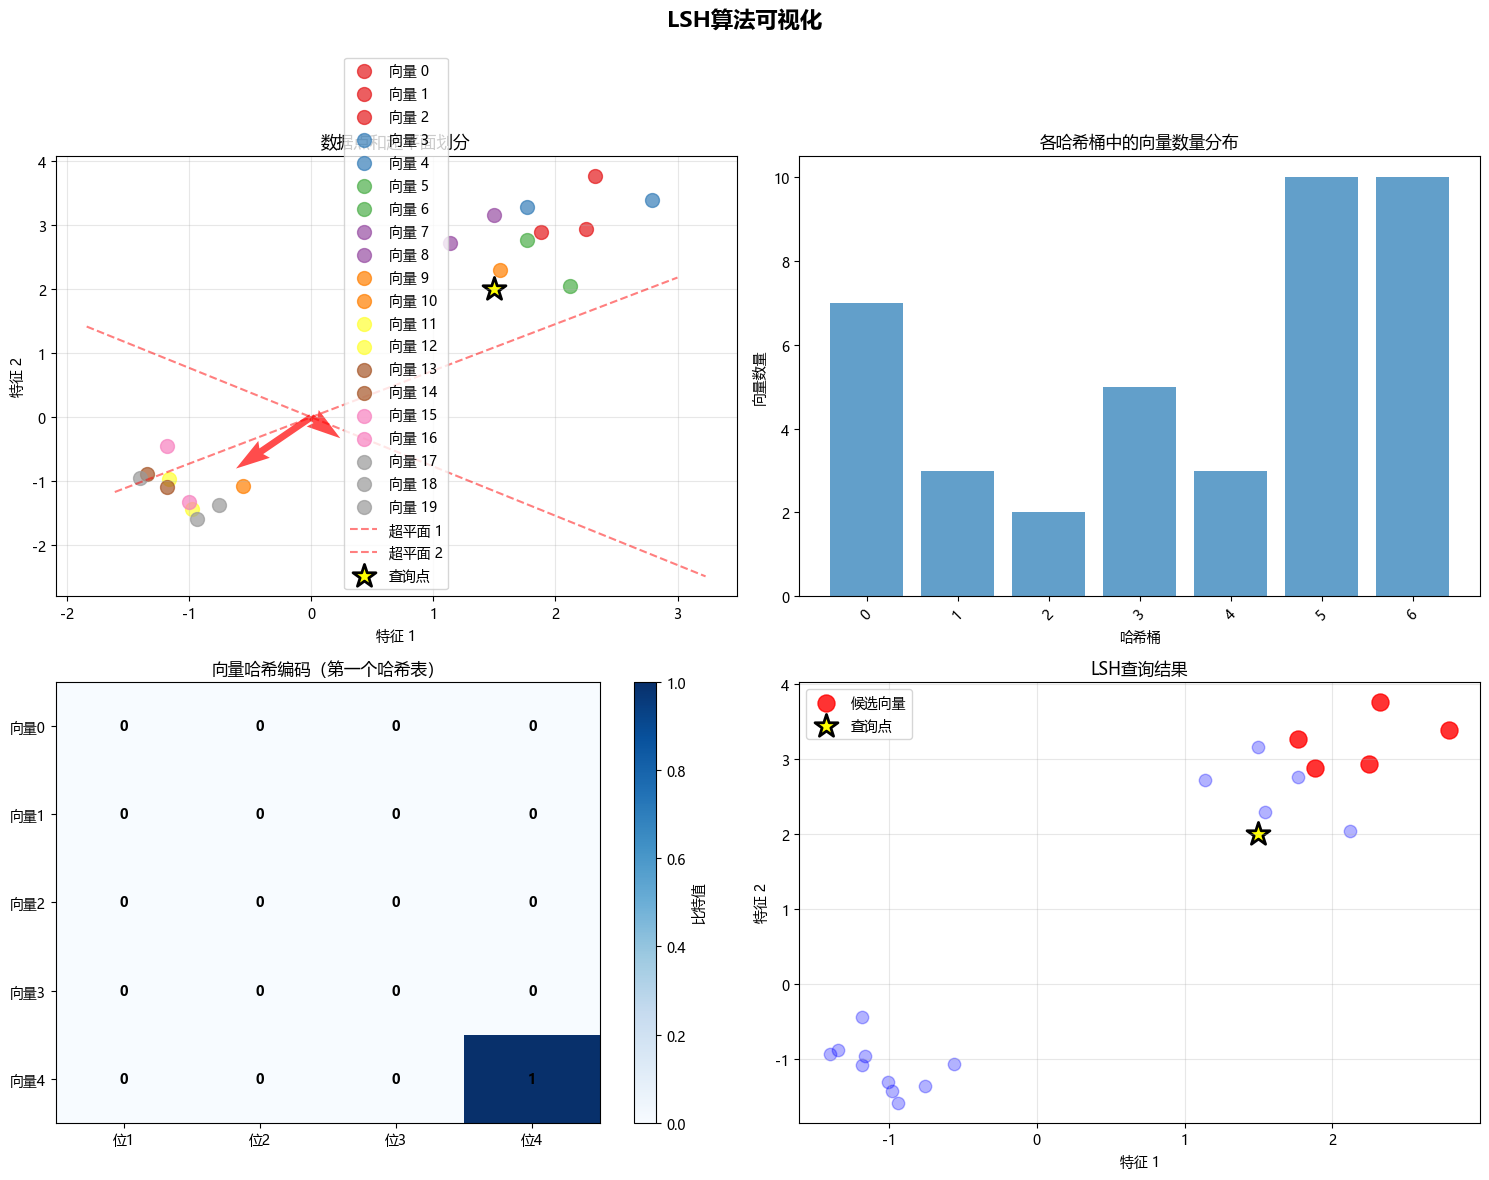

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB', 'STHeiti', 'PingFang SC', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
class VisualizableLSH:
    """
    可可视化的局部敏感哈希（LSH）实现，基于随机超平面投影
    适用于余弦相似度搜索
    """
    
    def __init__(self, hash_size=4, num_tables=3, dimension=2):
        """
        初始化LSH参数
        
        参数:
        - hash_size: 每个哈希表的位数（超平面数量）
        - num_tables: 哈希表数量
        - dimension: 数据维度
        """
        self.hash_size = hash_size
        self.num_tables = num_tables
        self.dimension = dimension
        self.hash_tables = [{} for _ in range(num_tables)]
        self.random_planes_list = []
        self.data_points = []
        self.is_trained = False
        
        # 生成随机超平面（法向量）
        self._generate_random_planes()
        
    def _generate_random_planes(self):
        """生成随机超平面法向量"""
        for i in range(self.num_tables):
            # 生成随机超平面法向量，以原点为中心
            planes = np.random.randn(self.hash_size, self.dimension) - 0.5
            self.random_planes_list.append(planes)
        self.is_trained = True
    
    def _hash_vector(self, vector, plane_norms):
        """计算单个向量的哈希值（二进制编码）"""
        # 计算向量与每个超平面法向量的点积
        projections = np.dot(vector, plane_norms.T)
        # 根据点积符号生成二进制编码
        hash_bits = (projections > 0).astype(int)
        # 转换为二进制字符串作为哈希键
        return ''.join(hash_bits.astype(str))
    
    def add_vector(self, vector, vector_id=None):
        """向LSH索引中添加向量"""
        if vector_id is None:
            vector_id = len(self.data_points)
        
        self.data_points.append(vector)
        
        # 将向量添加到所有哈希表
        for table_idx in range(self.num_tables):
            hash_key = self._hash_vector(vector, self.random_planes_list[table_idx])
            
            if hash_key in self.hash_tables[table_idx]:
                self.hash_tables[table_idx][hash_key].append(vector_id)
            else:
                self.hash_tables[table_idx][hash_key] = [vector_id]
        
        return vector_id
    
    def query(self, query_vector, max_results=5):
        """查询相似向量"""
        candidates = set()
        
        # 在所有哈希表中查找候选向量
        for table_idx in range(self.num_tables):
            hash_key = self._hash_vector(query_vector, self.random_planes_list[table_idx])
            if hash_key in self.hash_tables[table_idx]:
                candidates.update(self.hash_tables[table_idx][hash_key])
        
        # 如果没有找到精确匹配，查找汉明距离最近的桶
        if not candidates:
            print("未找到精确匹配，正在搜索邻近桶...")
            for table_idx in range(self.num_tables):
                original_key = self._hash_vector(query_vector, self.random_planes_list[table_idx])
                # 查找汉明距离为1的邻近桶
                for i in range(len(original_key)):
                    neighbor_key = list(original_key)
                    neighbor_key[i] = '1' if neighbor_key[i] == '0' else '0'
                    neighbor_key = ''.join(neighbor_key)
                    if neighbor_key in self.hash_tables[table_idx]:
                        candidates.update(self.hash_tables[table_idx][neighbor_key])
        
        candidate_ids = list(candidates)[:max_results]
        candidate_vectors = [self.data_points[i] for i in candidate_ids]
        
        return candidate_ids, candidate_vectors
    
    def get_hash_stats(self):
        """获取哈希表统计信息"""
        stats = {
            'total_vectors': len(self.data_points),
            'total_buckets': 0,
            'table_details': []
        }
        
        for i, table in enumerate(self.hash_tables):
            num_buckets = len(table)
            vectors_in_table = sum(len(bucket) for bucket in table.values())
            avg_size = vectors_in_table / num_buckets if num_buckets > 0 else 0
            
            stats['table_details'].append({
                'table_index': i,
                'num_buckets': num_buckets,
                'total_vectors': vectors_in_table,
                'average_bucket_size': avg_size
            })
        
        stats['total_buckets'] = sum(detail['num_buckets'] for detail in stats['table_details'])
        return stats

def visualize_lsh_process(lsh, query_vector=None, highlight_vector=None):
    """可视化LSH哈希过程"""
    
    if len(lsh.data_points) == 0:
        print("没有数据可可视化")
        return
    
    # 如果数据维度大于2，使用PCA降维
    if lsh.dimension > 2:
        pca = PCA(n_components=2)
        all_vectors = np.array(lsh.data_points + ([query_vector] if query_vector is not None else []))
        vectors_2d = pca.fit_transform(all_vectors)
        
        data_2d = vectors_2d[:len(lsh.data_points)]
        if query_vector is not None:
            query_2d = vectors_2d[-1]
        else:
            query_2d = None
    else:
        data_2d = np.array(lsh.data_points)
        query_2d = query_vector
    
    # 创建可视化图表
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('LSH算法可视化', fontsize=16, fontweight='bold')
    
    # 子图1: 显示数据点和超平面
    ax1 = axes[0, 0]
    
    # 绘制数据点
    colors = plt.cm.Set1(np.linspace(0, 1, len(data_2d)))
    for i, point in enumerate(data_2d):
        ax1.scatter(point[0], point[1], c=[colors[i]], s=100, alpha=0.7, label=f'向量 {i}')
    
    # 绘制超平面（只显示第一个哈希表的前两个超平面）
    if len(lsh.random_planes_list) > 0:
        planes = lsh.random_planes_list[0]
        for j, plane in enumerate(planes[:2]):  # 只显示前两个超平面
            # 在2D空间中，超平面是直线
            if lsh.dimension > 2:
                # 对于高维数据，显示投影后的超平面方向
                plane_2d = pca.transform([plane])[0]
            else:
                plane_2d = plane
            
            # 计算超平面的法线方向
            norm = np.linalg.norm(plane_2d)
            if norm > 0:
                # 绘制超平面法线
                ax1.quiver(0, 0, plane_2d[0], plane_2d[1], 
                          angles='xy', scale_units='xy', scale=1, 
                          color='red', alpha=0.7, width=0.01)
                
                # 绘制超平面（垂直于法线）
                if abs(plane_2d[0]) > 1e-10:  # 避免除零
                    slope = -plane_2d[0] / plane_2d[1] if abs(plane_2d[1]) > 1e-10 else 1e10
                    x_vals = np.array(ax1.get_xlim())
                    y_vals = slope * (x_vals - 0) + 0
                    ax1.plot(x_vals, y_vals, 'r--', alpha=0.5, label=f'超平面 {j+1}')
    
    # 标记查询点（如果有）
    if query_2d is not None:
        ax1.scatter(query_2d[0], query_2d[1], c='yellow', marker='*', 
                   s=300, edgecolors='black', linewidth=2, label='查询点')
    
    ax1.set_title('数据点和超平面划分')
    ax1.set_xlabel('特征 1')
    ax1.set_ylabel('特征 2')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 子图2: 显示哈希桶分布
    ax2 = axes[0, 1]
    
    # 统计每个桶的向量数量
    bucket_sizes = []
    bucket_labels = []
    for table_idx, table in enumerate(lsh.hash_tables):
        for hash_key, vectors in table.items():
            bucket_sizes.append(len(vectors))
            bucket_labels.append(f'T{table_idx}_{hash_key[:4]}...')
    
    if bucket_sizes:
        ax2.bar(range(len(bucket_sizes)), bucket_sizes, alpha=0.7)
        ax2.set_title('各哈希桶中的向量数量分布')
        ax2.set_xlabel('哈希桶')
        ax2.set_ylabel('向量数量')
        ax2.tick_params(axis='x', rotation=45)
    
    # 子图3: 显示哈希编码
    ax3 = axes[1, 0]
    
    # 显示前几个向量的哈希编码
    display_count = min(5, len(lsh.data_points))
    hash_codes = []
    vector_labels = []
    
    for i in range(display_count):
        hash_code = lsh._hash_vector(lsh.data_points[i], lsh.random_planes_list[0])
        hash_codes.append([int(bit) for bit in hash_code])
        vector_labels.append(f'向量{i}')
    
    if hash_codes:
        im = ax3.imshow(hash_codes, cmap='Blues', aspect='auto')
        ax3.set_xticks(range(len(hash_code)))
        ax3.set_xticklabels([f'位{i+1}' for i in range(len(hash_code))])
        ax3.set_yticks(range(display_count))
        ax3.set_yticklabels(vector_labels)
        
        # 添加数值标注
        for i in range(len(hash_codes)):
            for j in range(len(hash_codes[0])):
                ax3.text(j, i, hash_codes[i][j], 
                        ha='center', va='center', fontweight='bold')
        
        ax3.set_title('向量哈希编码（第一个哈希表）')
        plt.colorbar(im, ax=ax3, label='比特值')
    
    # 子图4: 显示查询结果（如果有查询）
    ax4 = axes[1, 1]
    
    if query_2d is not None:
        # 执行查询
        candidate_ids, candidate_vectors = lsh.query(query_vector)
        
        # 绘制所有数据点
        for i, point in enumerate(data_2d):
            if i in candidate_ids:
                # 高亮候选向量
                ax4.scatter(point[0], point[1], c='red', s=150, 
                           alpha=0.8, label='候选向量' if i == candidate_ids[0] else "")
            else:
                ax4.scatter(point[0], point[1], c='blue', s=80, alpha=0.3)
        
        # 标记查询点
        ax4.scatter(query_2d[0], query_2d[1], c='yellow', marker='*', 
                   s=300, edgecolors='black', linewidth=2, label='查询点')
        
        ax4.set_title('LSH查询结果')
        ax4.set_xlabel('特征 1')
        ax4.set_ylabel('特征 2')
        ax4.grid(True, alpha=0.3)
        ax4.legend()
    else:
        # 如果没有查询，显示哈希表统计信息
        stats = lsh.get_hash_stats()
        ax4.text(0.1, 0.9, f"LSH索引统计:", fontsize=12, fontweight='bold')
        ax4.text(0.1, 0.8, f"向量总数: {stats['total_vectors']}", fontsize=10)
        ax4.text(0.1, 0.7, f"哈希表数量: {lsh.num_tables}", fontsize=10)
        ax4.text(0.1, 0.6, f"总桶数: {stats['total_buckets']}", fontsize=10)
        
        for i, detail in enumerate(stats['table_details']):
            ax4.text(0.1, 0.5 - i*0.1, 
                    f"表{detail['table_index']}: {detail['num_buckets']}个桶", 
                    fontsize=9)
        
        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.set_title('LSH索引统计信息')
        ax4.axis('off')
    
    plt.tight_layout()
    plt.show()

def demonstrate_lsh():
    """演示LSH算法的完整流程"""
    print("=" * 60)
    print("LSH算法完整演示")
    print("=" * 60)
    
    # 1. 创建示例数据（2维便于可视化）
    np.random.seed(42)
    n_samples = 20
    dim = 2
    
    # 生成具有聚类结构的数据
    cluster1 = np.random.normal(loc=[2, 3], scale=0.5, size=(n_samples//2, dim))
    cluster2 = np.random.normal(loc=[-1, -1], scale=0.3, size=(n_samples//2, dim))
    data = np.vstack([cluster1, cluster2])
    
    print(f"生成{len(data)}个{dim}维数据点")
    
    # 2. 创建并初始化LSH索引
    lsh = VisualizableLSH(hash_size=4, num_tables=2, dimension=dim)
    
    # 3. 向LSH索引中添加数据
    for i, vector in enumerate(data):
        lsh.add_vector(vector, i)
    
    print("LSH索引构建完成!")
    
    # 4. 显示统计信息
    stats = lsh.get_hash_stats()
    print(f"\nLSH索引统计:")
    print(f"向量总数: {stats['total_vectors']}")
    print(f"哈希表数量: {lsh.num_tables}")
    print(f"总桶数: {stats['total_buckets']}")
    
    for detail in stats['table_details']:
        print(f"表{detail['table_index']}: {detail['num_buckets']}个桶, "
              f"平均每个桶{detail['average_bucket_size']:.2f}个向量")
    
    # 5. 创建查询点
    query_point = np.array([1.5, 2.0])
    print(f"\n查询点: {query_point}")
    
    # 6. 执行查询
    candidate_ids, candidate_vectors = lsh.query(query_point, max_results=3)
    
    print(f"找到{len(candidate_ids)}个候选向量:")
    for i, vec_id in enumerate(candidate_ids):
        similarity = cosine_similarity([query_point], [data[vec_id]])[0][0]
        print(f"候选向量{vec_id}: 相似度={similarity:.4f}")
    
    # 7. 可视化整个过程
    print("\n生成可视化图表...")
    visualize_lsh_process(lsh, query_point)
    
    return lsh, data, query_point, candidate_ids

# 运行演示
lsh, data, query, candidates = demonstrate_lsh()


这个实现通过四个子图展示了LSH算法的关键过程：
1.数据点和超平面划分：显示原始数据分布和随机超平面如何划分空间
2.哈希桶分布：展示向量在不同哈希桶中的分布情况
3.向量哈希编码：用热图形式显示每个向量的二进制哈希编码
4.查询结果：高亮显示LSH找到的相似向量候选集


理解LSH算法的参数对掌握其工作原理至关重要：
- hash_size（哈希大小）：
> 作用：决定每个哈希表的哈希码长度（位数）
> 影响：值越大，哈希桶划分越精细，相似度判断越准确，但每个桶内的向量可能越少

- num_tables（哈希表数量）：
> 作用：控制使用的独立哈希表数量
>影响：值越大，找到真正近邻的概率越高，但内存消耗也会增加